In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42

# initialize output
wing_characters = dict()
wing_characters_stats = dict()

subdirs = [f'./real_samples/atap_20plus', f'./real_samples/atap_20plus_reconstructions512d', f'./real_samples/atap_20plus_reconstructions40d']

In [2]:
fw_img_files = []
hw_img_files = []
# 0 is real
for src in range(len(subdirs)):
    subdir = subdirs[src]
    fw_img_files = fw_img_files + [f'./{subdir}/fw/{f}' for f in os.listdir(f'{subdir}/fw') if f.endswith('.png')]
    hw_img_files = hw_img_files + [f'./{subdir}/hw/{f}' for f in os.listdir(f'{subdir}/hw') if f.endswith('.png')]

    fw_img_files.sort()
    len(fw_img_files)

    hw_img_files.sort()
    len(hw_img_files)

In [3]:
# fw_img_files

In [4]:
def get_src (f):
    if '40d' in f:
        return 'rec40d'
    elif '512d' in f:
        return 'rec512d'
    else:
        return 'real'

In [5]:
wings_df = pd.DataFrame({'file' :fw_img_files + hw_img_files})
wings_df['src'] = [get_src(f) for f in (fw_img_files + hw_img_files)]

In [6]:
wings_df

,file,src
0,././moth_geometry/real_samples/atap_20plus/fw/...,real
1,././moth_geometry/real_samples/atap_20plus/fw/...,real
2,././moth_geometry/real_samples/atap_20plus/fw/...,real
3,././moth_geometry/real_samples/atap_20plus/fw/...,real
4,././moth_geometry/real_samples/atap_20plus/fw/...,real
...,...,...
355,././moth_geometry/real_samples/atap_20plus_rec...,rec512d
356,././moth_geometry/real_samples/atap_20plus_rec...,rec512d
357,././moth_geometry/real_samples/atap_20plus_rec...,rec512d
358,././moth_geometry/real_samples/atap_20plus_rec...,rec512d


In [7]:
wings_df['family'] = [f.split('/')[-1].split('_')[0] for f in (fw_img_files + hw_img_files)]
wings_df['wing'] = [f.split('/')[-2] for f in (fw_img_files + hw_img_files)]
#wings_df.to_csv('fam_wings_df.csv', index=False, sep='\t')
wings_df.sort_values('file', ascending=True, inplace=True)

In [9]:
wings_df.head()
wings_df.tail()

,file,src,family,wing
355,././moth_geometry/real_samples/atap_20plus_rec...,rec512d,Tineidae,hw
356,././moth_geometry/real_samples/atap_20plus_rec...,rec512d,Tineidae,hw
357,././moth_geometry/real_samples/atap_20plus_rec...,rec512d,Tortricidae,hw
358,././moth_geometry/real_samples/atap_20plus_rec...,rec512d,Tortricidae,hw
359,././moth_geometry/real_samples/atap_20plus_rec...,rec512d,Tortricidae,hw


In [10]:
wings_df_unique = wings_df.copy()#[~wings_df[['family', 'wing', 'src']].duplicated()]
# wings_df_unique.sort_values(['wing', 'family'], inplace=True)
# wings_df_unique.reset_index(inplace=True, drop=True)

In [11]:
# wings_df_unique.loc[wings_df_unique[['family', 'wing', 'src']].duplicated(), 'src'] = 'real_rec'

In [12]:
# wings_df_unique = wings_df_unique[~wings_df_unique[['family', 'wing', 'src']].duplicated()]

In [13]:
wings_df_unique[wings_df_unique.src=='rec512d']

,file,src,family,wing
120,././moth_geometry/real_samples/atap_20plus_rec...,rec512d,Crambidae,fw
121,././moth_geometry/real_samples/atap_20plus_rec...,rec512d,Crambidae,fw
122,././moth_geometry/real_samples/atap_20plus_rec...,rec512d,Crambidae,fw
123,././moth_geometry/real_samples/atap_20plus_rec...,rec512d,Drepanidae,fw
124,././moth_geometry/real_samples/atap_20plus_rec...,rec512d,Drepanidae,fw
...,...,...,...,...
355,././moth_geometry/real_samples/atap_20plus_rec...,rec512d,Tineidae,hw
356,././moth_geometry/real_samples/atap_20plus_rec...,rec512d,Tineidae,hw
357,././moth_geometry/real_samples/atap_20plus_rec...,rec512d,Tortricidae,hw
358,././moth_geometry/real_samples/atap_20plus_rec...,rec512d,Tortricidae,hw


In [14]:
# fw_set = set(wings_df_unique[wings_df_unique.wing=='FW'].family.values)
# hw_set = set(wings_df_unique[wings_df_unique.wing=='HW'].family.values)
# fw_set - hw_set

fw_img_files = wings_df_unique[wings_df_unique.wing=='fw'].file.values
hw_img_files = wings_df_unique[wings_df_unique.wing=='hw'].file.values

fw_srcs = wings_df_unique[wings_df_unique.wing=='fw'].src.values
hw_srcs = wings_df_unique[wings_df_unique.wing=='hw'].src.values

# 去背影像二值化
def binarify(img, k=(1,1), iterations=5):
    #img_bg_idx = np.where((img[:,:,0]==0) & (img[:,:,1]==0) & (img[:,:,2]==0))
    img_bg_idx = np.where(img[:,:,3]==0)
    binary = np.ones(img.shape[:2], dtype=np.uint8)
    binary[img_bg_idx] = 0
    # 清掉沒去背乾淨的渣渣
    if iterations >= 1:
        binary = cv2.erode(binary, k, iterations=iterations)
        #binary = cv2.dilate(binary, k, iterations=iterations)
    return binary

# 從二值影像產出 bounding box
def bbox_crop(binary):
    cntrs, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    bbox_x, bbox_y, bbox_w, bbox_h = cv2.boundingRect(cntrs[0])
    return binary[bbox_y:bbox_y+bbox_h, bbox_x:bbox_x+bbox_w], [bbox_x, bbox_y, bbox_x+bbox_w, bbox_y+bbox_h]

# 取出前景所在的 pixel y, x 坐標值
def take_fg_pixels(img, img_binary):
    y_, x_ = np.where(img_binary==1)
    return img[y_, x_], (y_, x_)

# 取出亮度值的指定百分位數
def hsv_vp(per, hsvs):
    return np.quantile(np.concatenate(hsvs)[:,2], per/100)

# 計算 Convex Hull 面積
def PolyArea2D(pts):
    lines = np.hstack([pts,np.roll(pts,-1,axis=0)])
    area = 0.5*abs(sum(x1*y2-x2*y1 for x1,y1,x2,y2 in lines))
    return area

def minMaxScaler(v):
    return (v - v.min()) / (v.max() - v.min())

# test_wid = 32

# fw_img = cv2.imread(f'{fw_img_files[test_wid]}', cv2.IMREAD_UNCHANGED)
# hw_img = cv2.imread(f'{fw_img_files[test_wid]}'.replace('FW', 'HW'), cv2.IMREAD_UNCHANGED)

# fw_binary = binarify(fw_img)
# fw_cropped, _ = bbox_crop(fw_binary)

# plt.rcParams['figure.figsize'] = [5, 5]
# #plt.imshow(fw_img * fw_binary.reshape(*fw_binary.shape, 1))
# plt.imshow(fw_binary)
# plt.show()

# plt.rcParams['figure.figsize'] = [5, 5]
# plt.imshow(fw_cropped)

In [30]:
# 指定前後翅，前翅 fw, 後翅 hw, 兩者一起 both。分析時就只分別看前後翅了
target_wings = 'fw'
# target_wings = 'hw'
# target_wings = 'both'

if target_wings == 'fw':
    target_img_files = fw_img_files
    target_srcs = fw_srcs
elif target_wings == 'hw':
    target_img_files = hw_img_files
    target_srcs = hw_srcs
elif target_wings == 'both':
    target_img_files = fw_img_files + hw_img_files
    target_srcs = fw_srcs + hw_srcs
else:
    raise ('Wrong wing part.')

In [31]:
# # 前景的 RGB 值
# rgbs = []
# # 前景的 HSV 值
# hsvs = []

# grays = []

# 前景所在的 y, x 坐標值
img_fg_idxs = []

bboxes = []
w_binarys = []

for idx_, w_ in enumerate(target_img_files):
    w_img = cv2.imread(f'{w_}', cv2.IMREAD_UNCHANGED)
#     print(w_)
    mask = w_img[:,:,3].copy()
#     src = wings_df_unique[wings_df_unique.file==w_].src.values[0]
    src = target_srcs[idx_]
    
#     if src == 'real_rec':
#         w_img_rec_512d = cv2.imread(f'{w_.replace("atap_20plus", "atap_20plus_reconstructions40d").replace(".png", ".jpg_rec40d.png").replace(f"{target_wings}/", "")}', cv2.IMREAD_UNCHANGED)
#         w_img[:,:,:3] = w_img_rec_512d
    if src == 'real':
        for i in range(1):
            w_img = cv2.blur(w_img, (7, 7))
        w_img[:,:,3] = mask
    
    w_binary = binarify(w_img)
    w_binarys.append(w_binary)

    w_img = cv2.cvtColor(w_img, cv2.COLOR_BGR2RGB)
    w_img_gray = cv2.cvtColor(w_img, cv2.COLOR_RGB2GRAY)
    # w_img = cv2.normalize(w_img.astype(float)/255, None, 1, 0, cv2.NORM_MINMAX)
    #w_img = (w_img * 255).astype(np.uint8)

    w_img_hsv = cv2.cvtColor(w_img, cv2.COLOR_RGB2HSV)
    w_cropped, bbox = bbox_crop(w_binary)
    bboxes.append(bbox)
    
    w_rgb, img_fg_idx = take_fg_pixels(w_img, w_binary)
    img_fg_idxs.append(img_fg_idx)
#     rgbs.append(w_rgb)
    
#     w_gray, _ = take_fg_pixels(w_img_gray, w_binary)
#     grays.append(w_gray)
    
#     w_hsv, _ = take_fg_pixels(w_img_hsv, w_binary)
#     hsvs.append(w_hsv)

# # 翅膀暗區比例 (暗於所有翅膀 pixels 點的 q .25 佔翅膀的比例)
# dark_area = np.array([((w_<hsv_vp(25, hsvs)).sum()+0) / len(w_) for w_ in hsvs])
# # 翅膀亮區比例 (亮於所有翅膀 pixels 點的 q .25 佔翅膀的比例)
# light_area = np.array([((w_>hsv_vp(75, hsvs)).sum()+0) / len(w_) for w_ in hsvs])
# # 翅膀平均色調(無意義)、平均飽和度、平均亮度
# hsv_mean = np.array([w_.mean(axis=0) for w_ in hsvs])
# # 亮區與暗區的比例
# lit2dar = light_area / dark_area
# # 翅膀色調(無意義)、飽和度、亮度標準差
# hsv_stds = np.array([np.std(w_, axis=0) for w_ in hsvs])

# gray_mean = np.array([w_.mean(axis=0) for w_ in grays])

# # RGB 各自的標準差
# rgb_stds = np.array([np.std(w_, axis=0) for w_ in rgbs])
# # RGB 各自的平均值
# rgb_means = np.array([np.mean(w_, axis=0) for w_ in rgbs])

# from sklearn.cluster import OPTICS, DBSCAN, KMeans, Birch
# cls = Birch(n_clusters=None, threshold=16)
# #cls = Birch(n_clusters=32)#, threshold=16)
# #cls = OPTICS(min_samples=220, max_eps=16)
# color_groups = cls.fit_predict(np.concatenate(rgbs).astype(float))

# idx_counter = 0
# wing_color_groups = []
# distinct_colors = []
# for color in rgbs:
#     wing_color_group = color_groups[idx_counter:idx_counter+color.shape[0]]
#     wing_color_groups.append(wing_color_group)
#     distinct_colors.append(np.unique(wing_color_group).shape[0])
#     idx_counter += color.shape[0]

# color_evenness = []
# for wing_i, wing_color_group_ in enumerate(wing_color_groups):
#     distinct_wing_colors_, color_counts_ = np.unique(wing_color_group_, return_counts=True)
#     H = -np.sum([(p/len(wing_color_group_)) * np.log(p/len(wing_color_group_)) for p in color_counts_])
#     J = H / np.log(len(color_counts_))
#     color_evenness.append(J)

# # plt.rcParams['figure.figsize'] = [20, 40]
# # num_cols = 8
# # num_rows = np.ceil(len(target_img_files) / num_cols).astype(int)
# # fig, axes = plt.subplots(num_rows, num_cols)
# # distinct_color_canvases = []
# # for i, img_fg_idx in enumerate(img_fg_idxs):
# #     #print(target_img_files[i])
# #     img_color_groups = wing_color_groups[i]
# #     #canvas = np.zeros((max(img_fg_idx[0])+1, max(img_fg_idx[1])+1, 3), dtype=np.uint8)
# #     canvas = np.zeros([256, 256, 3], dtype=np.uint8)
# #     #print(max(img_color_groups)+1)
# #     for c in range(0,max(img_color_groups)+1):
# #         try:
# #             c_mean = np.mean(rgbs[i][img_color_groups==c], axis=0)
# #             canvas[img_fg_idx[0][img_color_groups==c], img_fg_idx[1][img_color_groups==c]] = c_mean.astype(np.uint8)
# #         except:
# #             print(f'Missing color group {c} for image {target_img_files[i]}.')
# #         #canvas[img_fg_idx[0][img_color_groups==c], img_fg_idx[1][img_color_groups==c]] = rgbs[i][img_color_groups==c]
# #     distinct_color_canvases.append(canvas.copy())
# #     axes[int(i//num_cols), i%num_cols].imshow(distinct_color_canvases[-1])
# #     sub_title = target_img_files[i].split('/')[-1]
# #     axes[int(i//num_cols), i%num_cols].set_title(f'{sub_title}')

# # plt.show()

# # plt.rcParams['figure.figsize'] = [40, 35]
# # num_cols = 8
# # num_rows = np.ceil(len(target_img_files) / num_cols).astype(int)
# # fig, axes = plt.subplots(num_rows, num_cols)
# xflip_distinct_color_canvases = []
# for i, img_fg_idx in enumerate(img_fg_idxs):
#     #print(target_img_files[i])
#     img_color_groups = wing_color_groups[i]
#     #canvas = np.zeros((max(img_fg_idx[0])+1, max(img_fg_idx[1])+1, 3), dtype=np.uint8)
#     #canvas = np.zeros([256, 256, 3], dtype=np.uint8)
#     canvas = np.ones([256, 256, 3], dtype=np.uint8) * 255
#     #print(max(img_color_groups)+1)
#     for c in range(0,max(img_color_groups)+1):
#         try:
#             c_mean = np.mean(rgbs[i][img_color_groups==c], axis=0)
#             canvas[img_fg_idx[0][img_color_groups==c], img_fg_idx[1][img_color_groups==c]] = c_mean.astype(np.uint8)
#         except:
#             print(f'Missing color group {c} for image {target_img_files[i]}.')
#         #canvas[img_fg_idx[0][img_color_groups==c], img_fg_idx[1][img_color_groups==c]] = rgbs[i][img_color_groups==c]
#     xflip_distinct_color_canvases.append(canvas.copy())
#     # axes[int(i//num_cols), i%num_cols].imshow(xflip_distinct_color_canvases[-1])
#     # sub_title = target_img_files[i].split('/')[-1]
#     # axes[int(i//num_cols), i%num_cols].set_title(f'{sub_title}')

# # plt.savefig(f'wing_characters/fam_{target_wings}_colors_20230510.pdf')
# # plt.close()
# # plt.show()


# #########################################################
# from sklearn.metrics import pairwise_distances

# # fig, axes = plt.subplots(6,5)
# # plt.rcParams['figure.figsize'] = [40, 35]
# plt.rcParams['figure.figsize'] = [36, 60]
# # # wing_fig_, wing_axes_ = plt.subplots(27, 3)

# num_cols = 6
# num_rows = np.ceil(len(target_img_files) / num_cols).astype(int)
# wing_fig_, wing_axes_ = plt.subplots(num_rows, num_cols)

# feat_on_x_edge_indices = []
# feat_on_y_edge_indices = []

# def qmean(group_dt, var, q):
#     qv = np.quantile(group_dt[var], q)
#     vals_ = group_dt[group_dt[var] >= qv][var]
#     return vals_.mean()

# wing_i = 32
# for wing_i in range(len(rgbs)):
    
#     print(wing_i, end='\r')
    
#     # 計算前景(翅膀) RGB 值中，任兩點的 歐式距離
#     pwd_rgb = pairwise_distances(rgbs[wing_i])
    
#     # 轉回影像的 xy 平面
#     #     xy_pwds = []
#     #     for i_ in range(len(img_fg_idxs[wing_i][0])):
#     #         for j_ in range(len(img_fg_idxs[wing_i][0])):
#     #             xy_pwds.append((img_fg_idxs[wing_i][1][i_], img_fg_idxs[wing_i][0][i_], pwd_rgb[i_][j_]))

#     #     xy_pwds_df = pd.DataFrame(xy_pwds, columns=['x','y','pwd'])

#     xy_pwds_df = pd.DataFrame(np.repeat(np.array([img_fg_idxs[wing_i][1], img_fg_idxs[wing_i][0]]).T, img_fg_idxs[wing_i][1].shape[0], axis=0), columns=['x', 'y'])
#     xy_pwds_df['pwd'] = pwd_rgb.reshape(-1)
    
    
#     # 算出每個點到任意其他點的 RGB 歐式距離平均，這個值愈大代表該部位顏色愈獨特
#     xy_pwds_mean_df = xy_pwds_df.groupby(['x', 'y']).mean().reset_index()
#     xy_pwds_mean_df['pwd_valid'] = xy_pwds_mean_df['pwd'].values
    
#     # 抑制 q .95 以上的值，減緩修圖時造成的邊緣雜訊
#     xy_pwds_mean_df.loc[xy_pwds_mean_df.pwd > xy_pwds_mean_df.pwd.quantile(.95), 'pwd_valid'] = xy_pwds_mean_df.pwd.quantile(.95)
    
#     # 對獨特性做 min max scaling 標準化
#     xy_pwds_mean_df['pwd_norm'] = (xy_pwds_mean_df['pwd_valid'] - xy_pwds_mean_df['pwd_valid'].min()) / (xy_pwds_mean_df['pwd_valid'].max() - xy_pwds_mean_df['pwd_valid'].min())
#     # 改成用理論 max 值標準化，不然那些平平無奇的翅膀也算起來也可能變得很 diverse
#     # xy_pwds_mean_df['pwd_norm'] = xy_pwds_mean_df['pwd_valid'] / np.sqrt(3 * 255**2)
#     # xy_pwds_mean_df['pwd_norm'] = xy_pwds_mean_df['pwd_valid'] / xy_pwds_mean_df['pwd_valid'].min()

#     # 水平翻轉翅膀，讓 x 坐標與翅基-翅尖方向一致，並且將 x 值做 min max scaling
#     xy_pwds_mean_df['x_norm'] = (xy_pwds_mean_df.x.max() - xy_pwds_mean_df.x) / (xy_pwds_mean_df.x.max() - xy_pwds_mean_df.x.min())
#     # 將 y 值做 min max scaling
#     # xy_pwds_mean_df['y_norm'] = (xy_pwds_mean_df.y - xy_pwds_mean_df.y.min()) / (xy_pwds_mean_df.y.max() - xy_pwds_mean_df.y.min())
#     # 將色彩的獨特性與距離翅基的距離加權
#     # xy_pwds_mean_df['pwd_x_weighted'] = xy_pwds_mean_df.x_norm * xy_pwds_mean_df.pwd_norm
#     # xy_pwds_mean_df['pwd_y_weighted'] = xy_pwds_mean_df.y_norm * xy_pwds_mean_df.pwd_norm

#     # 參考 x 對獨特性加權值做平均，用來看獨特色彩主要分部的 x 位置
#     # feat_on_x_edge_indice = xy_pwds_mean_df.groupby('x').mean().pwd_x_weighted.values.mean()
#     # 改成用 pwd groupby x 的前 P % 值做平均比較有代表性
#     pixel_column_means = xy_pwds_mean_df.groupby('x_norm').apply(qmean, 'pwd_norm', .5)
#     # pixel_column_means = xy_pwds_mean_df.groupby('x_norm').mean()
    
#     # distinctiveness_prN = pixel_column_means[pixel_column_means >= 0.7]
#     loc_prN = pixel_column_means.index.values[pixel_column_means.values >= np.quantile(pixel_column_means.values, .5)]
#     # distinctiveness_x_weighted = pixel_column_means.index.values * pixel_column_means.pwd_norm.values
#     feat_on_x_edge_indice = loc_prN.mean() / loc_prN.var() #distinctiveness_x_weighted.mean()# / distinctiveness_x_weighted.var()
#     # feat_on_x_edge_indice = pixel_column_means.mean()
#     feat_on_x_edge_indices.append(feat_on_x_edge_indice)

#     # xflip_distinct_color_canvases[wing_i][::-1,::-1,:].shape
#     tmp_ = xflip_distinct_color_canvases[wing_i][:,::-1,:]
#     cmap_ = plt.get_cmap('jet')
    
#     for _, row_ in xy_pwds_mean_df.iterrows():
#         re_distribute_for_cmap = row_.pwd_norm
#         heat = cmap_(re_distribute_for_cmap)[:3]
#         tmp_[int(row_.y), int(row_.x)] = np.round(np.array(heat) * 255)

#     # wing_axes_[wing_i//num_cols][wing_i%num_cols].imshow(xflip_distinct_color_canvases[wing_i][::-1,::-1,:])
#     wing_axes_[wing_i//num_cols][wing_i%num_cols].imshow(tmp_[::-1, :, :])
#     wing_axes_[wing_i//num_cols][wing_i%num_cols].set_xlim([0,256])
#     wing_axes_[wing_i//num_cols][wing_i%num_cols].set_ylim([0,256])
#     # wing_axes_[wing_i//num_cols][wing_i%num_cols].scatter(xy_pwds_mean_df.x, 256-xy_pwds_mean_df.y, c=xy_pwds_mean_df.pwd_norm, cmap=plt.get_cmap('jet'), s=1)
#     wing_fig_.suptitle(f'{"Hind Wing" if target_wings == "hw" else "Fore Wing"}')

#     sub_title = target_img_files[wing_i].split('/')[-1].split('_')[0]
#     wing_axes_[wing_i//num_cols][wing_i%num_cols].set_title(f'{sub_title}')
    
#     wing_axes_[wing_i//num_cols][wing_i%num_cols].get_xaxis().set_visible(False)
#     wing_axes_[wing_i//num_cols][wing_i%num_cols].get_yaxis().set_visible(False)
#     wing_fig_.tight_layout()

# len(feat_on_y_edge_indices)
# # plt.savefig(f'wing_characters/fam_{target_wings}_highlights_20230518.pdf')
# # plt.close()

In [32]:
# xy_pwds_df

In [33]:
###########################################
hole_ratios = []
peri2areas = []

for wing_i in range(len(img_fg_idxs)):
    #wing_i = 8
    x_max = max(img_fg_idxs[wing_i][1])
    x_min = min(img_fg_idxs[wing_i][1])
    y_max = max(img_fg_idxs[wing_i][0])
    y_min = min(img_fg_idxs[wing_i][0])

    #canvas = np.zeros((y_max-y_min+1, x_max-x_min+1), np.uint8)
    canvas = np.zeros((256, 256, 3), np.uint8)
    canvas_binary = np.zeros((256, 256), np.uint8)
    # canvas_contour_area = np.zeros((256, 256), np.uint8)
    
    for fg_i in range(len(img_fg_idxs[wing_i][1])):
        x = img_fg_idxs[wing_i][1][fg_i]# - x_min
        y = img_fg_idxs[wing_i][0][fg_i]# - y_min
        canvas_binary[y, x] = 1

    cntrs, _ = cv2.findContours(canvas_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    for cntr_i, cntr_ in enumerate(cntrs):
        #cvhull = cv2.convexHull(cntrs[cntr_i])
        #cvhull_area = PolyArea2D(cvhull.reshape(-1, 2))
        
        peri = cv2.arcLength(cntr_, True)
        peri2area = peri / cv2.contourArea(cntr_)
        
        approx = cv2.approxPolyDP(cntr_, 0.01 * peri, True)
        approx_area = cv2.contourArea(approx)
        approx_cvhull = cv2.convexHull(approx)
        approx_cvhull_area = cv2.contourArea(approx_cvhull) #PolyArea2D(approx_cvhull.reshape(-1, 2))

        if approx_area > 500:
            break

    if approx_area <= 500:
        print('Error again, stop here.')
        break

    peri2areas.append(peri2area)
    hole_ratios.append(1 - approx_area / approx_cvhull_area)

#######################################################
target_measurements = dict(
#     color_saturation = hsv_mean[:, 1],
#     color_brightness = gray_mean,
#     color_richness = distinct_colors,
#     color_evenness = color_evenness,
#     rgb_red = rgb_means[:, 0],
#     rgb_green = rgb_means[:, 1],
#     rgb_blue = rgb_means[:, 2],
#     distinctive_from_wing_base = feat_on_x_edge_indices,
    # misc_convex_ratio = hole_ratios,
    perimeter_over_area = peri2areas,
    # proxy_area = proxy_areas,
    # box_aspect_ratio = proxy_aspect_ratios,
)

famv = []
for w_ in target_img_files:
    famv.append(w_.split('/')[-1].split('_')[0])

wing_characters[target_wings] = pd.DataFrame(dict(family = famv, src = wings_df_unique.src[wings_df_unique.wing==target_wings]))


for key in target_measurements.keys():
    target_var = target_measurements[key]
    wing_characters[target_wings][key] = target_var

In [34]:
wing_characters[target_wings]

,family,src,perimeter_over_area
0,Crambidae,real,0.089986
1,Crambidae,real,0.055245
2,Crambidae,real,0.078617
3,Drepanidae,real,0.061955
4,Drepanidae,real,0.057261
...,...,...,...
175,Tineidae,rec512d,0.107422
176,Tineidae,rec512d,0.107246
177,Tortricidae,rec512d,0.081155
178,Tortricidae,rec512d,0.073961


In [35]:
wing_characters[target_wings][wing_characters[target_wings].src=='real'].head()

,family,src,perimeter_over_area
0,Crambidae,real,0.089986
1,Crambidae,real,0.055245
2,Crambidae,real,0.078617
3,Drepanidae,real,0.061955
4,Drepanidae,real,0.057261


In [36]:
# from sklearn.preprocessing import MinMaxScaler

In [37]:
# scaler = MinMaxScaler()

In [38]:
target_wings = 'fw'
target_wings

'fw'

In [39]:
wing_characters_tmp0 = pd.DataFrame(wing_characters[target_wings][wing_characters[target_wings].src=='real'][target_measurements.keys()], columns=target_measurements.keys())
wing_characters_tmp1 = pd.DataFrame(wing_characters[target_wings][wing_characters[target_wings].src=='rec40d'][target_measurements.keys()], columns=target_measurements.keys())
wing_characters_tmp2 = pd.DataFrame(wing_characters[target_wings][wing_characters[target_wings].src=='rec512d'][target_measurements.keys()], columns=target_measurements.keys())

In [40]:
wing_characters_tmp0.to_csv(f'./rec_correlation_test/wing_characters_shape_related_{target_wings}_orig.csv', index=False, sep='\t')
wing_characters_tmp1.to_csv(f'./rec_correlation_test/wing_characters_shape_related_{target_wings}_rec40d.csv', index=False, sep='\t')
wing_characters_tmp2.to_csv(f'./rec_correlation_test/wing_characters_shape_related_{target_wings}_rec512d.csv', index=False, sep='\t')

In [41]:
# plt.rcParams['figure.figsize'] = [5, 5]
# for k in target_measurements:
#     plt.figure()
#     plt.scatter(wing_characters[0][target_wings][k], wing_characters[1][target_wings][k], s=50, alpha=.8)
#     plt.title(k)

No handles with labels found to put in legend.


perimeter_over_area 0.992852157413153 3.0006603779380856e-55


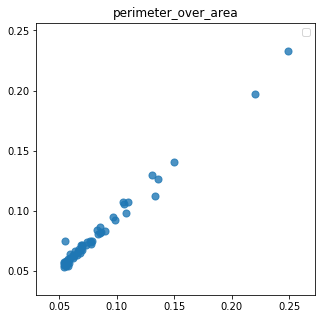

In [48]:
import scipy.stats as stats
plt.rcParams['figure.figsize'] = [5, 5]
var1 = wing_characters_tmp0
var2 = wing_characters_tmp2
for k in target_measurements:
    plt.figure()
#     plt.plot([0, 1], [0, 1], color='gray', linestyle='dashed')
#     plt.scatter(wing_characters_tmp0[k], wing_characters_tmp1[k], s=50, alpha=.8, label='512D')
#     plt.scatter(wing_characters_tmp0[k], wing_characters_tmp2[k], s=50, alpha=.8, label='40D')
    plt.scatter(var1[k], var2[k], s=50, alpha=.8)
#     slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(var1[k], var2[k])
    pearsons_r, p_value = stats.pearsonr(var1[k], var2[k])
    print(k, pearsons_r, p_value)
    plt.legend()
    plt.title(k)